## Discrete Population SEIR Simulations

Runs (1) simulation of the epidemic spreading, starting in Perth, and with discrete flows between towns decided by a binomial distribution.

Edited further to include some profiling so can check what bits of the code take a long time to run.

In [26]:
# Import those libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numpy import genfromtxt
import matplotlib.image as mpimg
import pandas as pd
import scipy
import time
from operator import add
from scipy.stats import binom
from numpy import random
import cProfile
import re
import collections

In [2]:
# Reads in a text file into an array
def readFile(fileName):
    fileObj = open(fileName, "r") #opens the file in read mode
    words = fileObj.read().splitlines() #puts the file into an array
    arr = []
    for item in words:
        arr.append(item.split('\t'))
    fileObj.close()
    return arr

In [4]:
# WALOC has town, population, long, latt
waloc = readFile('/Volumes/HardDrive/WALOC.txt')

In [5]:
# This bit just helps with the plotting function later
my_data = genfromtxt('/Volumes/HardDrive/WA_297_big/WA_297_20200322_20200328.txt', delimiter='\t')
A = nx.from_numpy_matrix(my_data)
A = nx.DiGraph(A)

# Generate labels for later (plotting) and for checking what town I'm dealing with
towns = [item[0] for item in waloc]
labeldict = {}
for node in list(A.nodes()):
    labeldict[node] = towns[node]

In [6]:
popn = [int(item[1].replace(',' , '')) for item in waloc][:58] #defined globally
print(popn)

[1874578, 71090, 31982, 29875, 29373, 25329, 15828, 13984, 13828, 10421, 8859, 7192, 6548, 6392, 6039, 4567, 4426, 4341, 4274, 4213, 3896, 3702, 3325, 2956, 2782, 2750, 2636, 2558, 2548, 2520, 2486, 2397, 2269, 2052, 2020, 1905, 1887, 1789, 1703, 1577, 1572, 1546, 1546, 1484, 1448, 1425, 1359, 1358, 1349, 1265, 1227, 1165, 1147, 1141, 1109, 1104, 80813, 780]


In [11]:
# Read in the adjacency matrices into a dictionary. Choose if wanting kalman filtered, or (kalman filtered and) stochasticised
wa_297 = os.listdir("/Volumes/HardDrive/stochasticised/")[:-1]
d = {}
for i in range(len(wa_297)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/stochasticised/"+wa_297[i], header = None, sep ='\t')*1*10**9

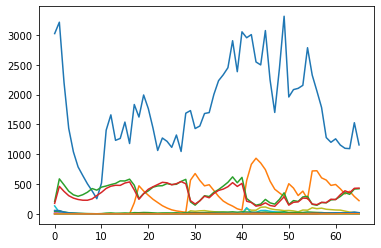

In [12]:
# (Only works if reading in 3 towns atm) plot the timeseries of the edges to see how they compare to one another
for j in range(0,10):
    a = []
    b = []
    for i in range(1,len(wa_297)):
        a.append(d[str(i)][5][j])
        b.append(d[str(i)][j][5])
    plt.plot(a)
    plt.plot(b)
a = []
b = []
for i in range(1,len(wa_297)):
    a.append(d[str(i)][1][2])
    b.append(d[str(i)][2][1])
plt.plot(a)
plt.plot(b)

In [13]:
# Create a df which is the average of all the flows, set it as key 100 in the dictionary 
# (so it's only referred to by choice)
df = d['0'].copy()
for i in range(1,len(wa_297)):
    df += d[str(i)]
df = df/len(wa_297)
d['100'] = df

In [14]:
for i in range(10):
    print(d['100'][5][i])

1755.1996794922713
357.64068750190216
4.11521992875406
6.393120036666445
32.40961752558508
0.0
21.476878038646458
4.1543481938971984
0.0
0.0


In [15]:
# Define the SEIR model equations (note the division by population as the key difference from the continuous case, 
# as well as doing the incoming/outgoing populations later)
def seir(params,x,popn):
    xdot = list(np.zeros(4*num))
    for i in range(num):
        xdot[4*i+0] = -params[5*i]*x[4*i]*x[4*i+2]/popn[i] - params[5*i+4]*x[4*i]   
        xdot[4*i+1] = params[5*i]*x[4*i]*x[4*i+2]/popn[i]  - params[5*i+1]*x[4*i+1] + params[5*i+3]*x[4*i+3]*x[4*i+2]/popn[i]
        xdot[4*i+2] = params[5*i+1]*x[4*i+1] - params[5*i+2]*x[4*i+2]
        xdot[4*i+3] = params[5*i+2]*x[4*i+2] + params[5*i+4]*x[4*i] - params[5*i+3]*x[4*i+3]*x[4*i+2]/popn[i]
    return xdot
    

In [16]:
# No longer maybe, this is *definitely* the binomial function. Takes in a discrete flow of population, 
# and based on the probability (p) of an individual being in the specified compartment in the initial (outgoing) town.
def maybe_binomialise(flow,p):
    if flow ==0:
        return 0
    else:
        dist = [binom.cdf(ppl, flow, p) for ppl in range(flow)]
        r1 = random.rand()
        for j in range(len(dist)):
            if r1 < dist[j]:
                move = j
                break
            else:
                move = flow
        return move

In [49]:
def bernoulli(flow,p1,p2,p3,p4):
    if flow == 0:
        return [0,0,0,0]
    else:
        vector = []
        for i in range(flow):
            r1 = random.rand()
            if r1 < p1:
                vector.append(0)
            elif (r1>p1) & (r1 < (p1+p2)):
                vector.append(1)
            elif (r1 > p1+p2) & (r1 < p1+p2+p3):
                vector.append(2)
            else:
                vector.append(3)
        occ = dict(collections.Counter(vector))
        for i in range(4):
            occ[i] = occ.get(i,0)
        return occ

In [48]:
a_list = [0, 1, 0]
occurrences = dict(collections. Counter(a_list))
print(occurrences)
list(occurrences.values())
for i in range(4):
    occurrences[i] = occurrences.get(i,0)
print(occurrences)

{0: 2, 1: 1}
{0: 2, 1: 1, 2: 0, 3: 0}


In [62]:
# The big one
def dynamics(x_init,days,crit,params,breaks,steps):
    x = x_init #Initial values for all towns!
    
    # Iterate over each day
    for day in range(days):
        print(day)
        
        # Step 1: if a town's number of infections has passed the critical value, immediately 'impose restrictions'
        # and decrease alpha so that R0 is roughly 1
        for i in range(num):
            if x[-1][4*i+2] > crit:
                params[5*i] = 0.13
                params[5*i +3 ] = 0.3*0.13
                
            if (x[-1][4*i+2] > 0) & (breaks[i][1] == 0):
                # Breaks has list of tuples - in each tuple, if the second entry is 1 the pandemic has reached the 
                # town, with the first entry being how long (days) it took to get there.
                breaks[i] = (day,1)
        
        # Step 2: Use the SEIR equation to simulate the spread over the day.
        for t in range(steps):
            xdot = seir(params, x[-1], popn)
            xdot = [i/steps for i in xdot]
            x.append([sum(i) for i in zip(*[x[-1],xdot])])
        
        # Step 3: If the 7th day of the week, get the flow and feed it into the binomial function, 
        # which will return how many people in that particular compartment moved from one town to the other.
        if day%7 == 0:
            week = int(day//7)
            if week < 67:
                flow = d[str(week)].copy()
            else:
                flow = d['100'].copy() #Average flow

            for i in range(num):
                for j in range(num):
                    #for k in range(4):
                        # Get discrete number moving from town i to town j in compartment k.
                    #    binn = maybe_binomialise(int(flow[i][j]),x[-1][4*i+k]/popn[i])
                    #    x[-1][4*j+k] += binn
                    #    x[-1][4*i+k] -= binn
                    pop = popn[i]
                    move = bernoulli(int(flow[i][j]),x[-1][4*i]/pop,x[-1][4*i+1]/pop,x[-1][4*i+2]/pop,x[-1][4*i+3]/pop)
                    for k in range(4):
                        x[-1][4*j+k] += move[k]
                        x[-1][4*i+k] -= move[k]
    return x, breaks

In [63]:
def plotting(y):
    s = list(zip(*y))

    for i in range(num):
        plt.figure(figsize = (6,6))
        plt.plot(s[4*i],'k', label ='Susceptible')
        plt.plot(s[4*i+1],'b', label = 'Exposed')
        plt.plot(s[4*i+2],'r', label = 'Infected')
        plt.plot(s[4*i+3],'y', label = 'Recovered/Vaccinated')
        plt.title(labeldict[i])
        plt.legend()
        plt.xlabel("Days")
        plt.ylabel("Number of infected")
        plt.xlim([0,steps*days])
        plt.ylim([0,1000])
        plt.tight_layout()

In [70]:
num = 58 #define globally

# Set the initial town values (when doing final simulations make sure this is accurate)
x_init = [1000000,0,10,popn[0]-1000000-10]
y_init = []
for i in range(1,num):
    y_init.append(int(popn[i]/2))
    y_init.append(0)
    y_init.append(0)
    y_init.append(int(popn[i]/2))
town_init = [x_init+y_init]

# Set number of days for this simulation
days = 700

# Set critical value at which to set R0 ~ 1
crit = 200

# [alpha, beta, gamma, omega, mu]
params = [0.2, 1/5.2, 1/12,0.09,0.0001]*num

#Initialise the outbreaks info
breaks = [(0,0)]*num

steps = 1

In [61]:
#With maybe_binomialise
cProfile.run('dynamics(town_init,days, crit, params, breaks,steps)')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [71]:
#With bernoulli
cProfile.run('dynamics(town_init,days, crit, params, breaks,steps)')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [53]:
# Call the function
y , breaks = dynamics(town_init,days, crit, params, breaks,steps)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [66]:
# Get info of where the outbreak reached and how long it took to get there
for i in range(num):
    if breaks[i][0] > 0:
        print(labeldict[i],breaks[i][0])
        
print('------Not Affected:------')
for i in range(num):
    if breaks[i][1] == 0:
        print(labeldict[i])

Bunbury 309
Geraldton 421
Kalgoorlie-Boulder 302
Albany 309
Busselton 232
Karratha 58
Broome 310
------Not Affected:------
Port Hedland
Esperance


IndexError: list index out of range

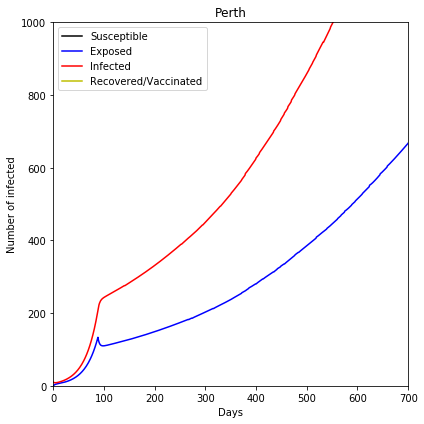

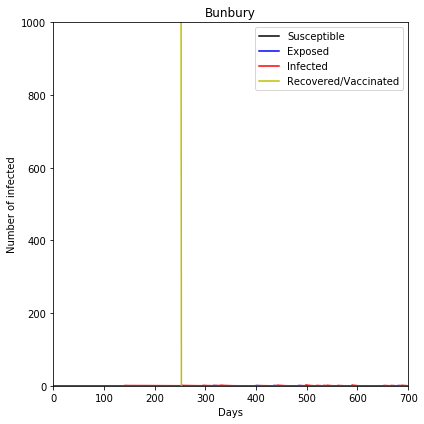

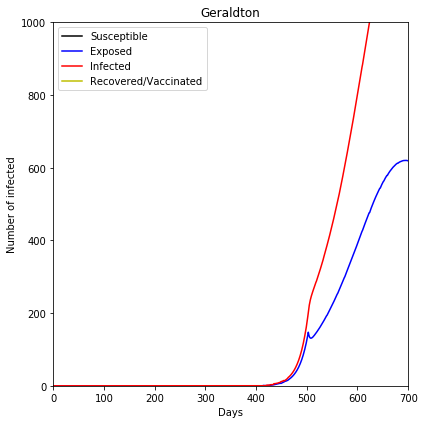

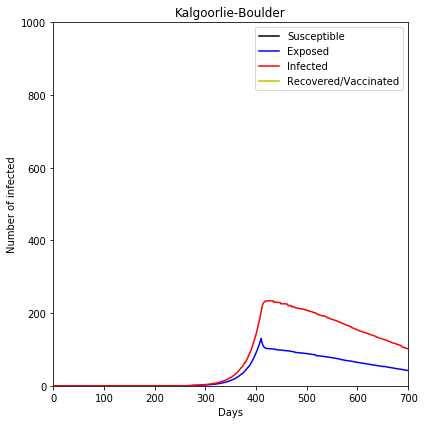

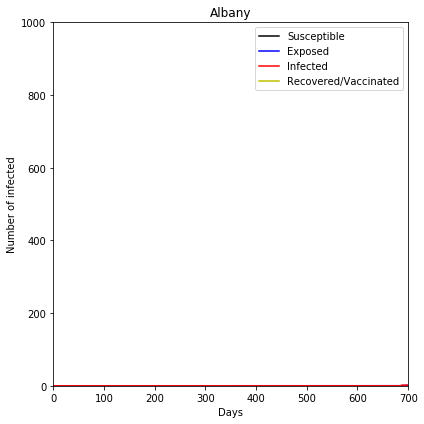

<Figure size 432x432 with 0 Axes>

In [67]:
plotting(y)